import packages

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

from statistics import mean, stdev

import warnings
warnings.filterwarnings("ignore")

## 1

In [2]:
bq_data = np.loadtxt('data\BQmat_orig.txt', delimiter=',')

### a

Text(0.5, 0, 'Percent of BQ received')

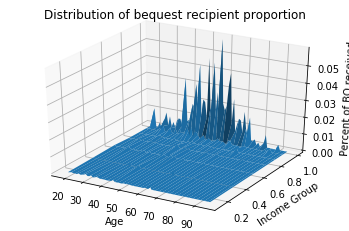

In [3]:
BQ_mat = bq_data / bq_data.sum()

# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

### b

In [4]:
bq_matrix = np.zeros((78*7,3))
for i in range(78):
    bq_matrix[7*i:7*(i+1),0] = i+18
    for j in range(7):
        bq_matrix[7*i+j,1] = j
for k in range(78*7):
    idx1 = int(bq_matrix[k,0]-18)
    idx2 = int(bq_matrix[k,1])
    bq_matrix[k,2] = bq_data[idx1,idx2]
for k in range(1,78*7):
    bq_matrix[k,2] += bq_matrix[k-1,2]
for i in range(78):
    for j in range(7):
        bq_matrix[7*i+j,1] = lambdas_mdpts[j]

In [5]:
def simulation(n):
    ages_vec = np.arange(18, 96)
    abils_midpt = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
    prop_mat_inc = np.sum(bq_data, axis=0)
    prop_mat_age = np.sum(bq_data, axis=1)
    N_samp = n
    age_probs = np.random.multinomial(N_samp, prop_mat_age)
    income_probs = np.random.multinomial(N_samp, prop_mat_inc)
    age_freq = np.array([])
    inc_freq = np.array([])

    # creating a distribution of age values
    for age, num_s in zip(ages_vec, age_probs):
        vec_age_s = np.ones(num_s)
        vec_age_s *= age
        age_freq = np.append(age_freq, vec_age_s)

    # creating a distribution of ability type values
    for abil, num_j in zip(abils_midpt, income_probs):
        vec_abil_j = np.ones(num_j)
        vec_abil_j *= abil
        inc_freq = np.append(inc_freq, vec_abil_j)
    return np.vstack((age_freq, inc_freq))
Data_sim = simulation(70000)

0.03


Text(0.5, 0, 'Percent of BQ received')

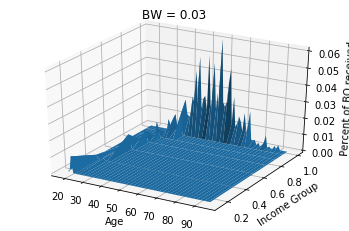

In [6]:
bw_best = 0.01
loss_best = np.inf
for i in range(20):
    bw = (i+1)*0.01
    kde = gaussian_kde(Data_sim, bw_method = bw)
    coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
    density = np.reshape(kde(coords), age_mat.shape)
    density_scaled = density/density.sum()
    loss = ((density_scaled - BQ_mat)**2).sum()
    if loss < loss_best:
        loss_best = loss
        bw_best = bw
print(bw_best)
kde = gaussian_kde(Data_sim, bw_method = bw_best)
coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
density = np.reshape(kde(coords), age_mat.shape)
density_scaled = density/density.sum()
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(age_mat, income_mat, density_scaled)
ax.set_title('BW = {:.2f}'.format(bw_best))
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

As shown above, bandwidth = 0.03 seems to fit best because the sum of squared error is the smallest.

In [7]:
print("Estimated density for bequest recipients who are age 61 in the 6th lifetime income category = ", density_scaled[43][5])

Estimated density for bequest recipients who are age 61 in the 6th lifetime income category =  4.5188065145506005e-52


## 2

In [8]:
Auto = pd.read_csv('data/Auto.csv',na_values = "?")
Auto.dropna(inplace=True)
Auto['orgn1'] = 0
Auto.orgn1[Auto['origin']==1] = 1
Auto['orgn2'] = 0
Auto.orgn2[Auto['origin']==2] = 1
Median = Auto['mpg'].median()
Auto['mpg_high'] = 0
Auto.mpg_high[Auto['mpg']>=Median] = 1

### a

In [9]:
y = Auto['mpg_high'].values
X = Auto[['cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'orgn1', 'orgn2']].values
time_start1 = time.clock()
MSE = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=i+100)
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_now = (y_test == y_pred).mean()
    MSE.append(MSE_now)
MSE_avg = mean(MSE)
time_end1 = time.clock()
print('average MSE=', MSE_avg)
print('computation time =',time_end1-time_start1,'seconds')

average MSE= 0.8976086956521739
computation time = 0.13751360300000215 seconds


### b

In [10]:
import multiprocessing
from dask import compute, delayed
import dask.multiprocessing

num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

def doublecheck(bootstrap, seed, Data):
    X, y = Data
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=seed+bootstrap)
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_now = (y_test == y_pred).mean()
    return MSE_now
time_start2 = time.clock()
MSE_2 = []
for i in range(100):
    MSE_2.append(delayed(doublecheck)(i,100,[X,y]))
MSE2_avg = delayed(mean)(MSE_2)
MSE2_avg = compute(MSE2_avg, num_workers=num_cores)[0]
time_end2 = time.clock()
print('average MSE=', MSE2_avg)
print('computation time =',time_end2-time_start2,'seconds')

Number of available cores is 8
average MSE= 0.8976086956521739
computation time = 0.0949800879999998 seconds
